In [1]:
%load_ext autoreload
%autoreload 2

import functools
import time
    
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tqdm import tqdm
import optax

import embedding_models
import maf_flow
import train

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-10-10 13:38:46.986506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Problem Setup

In [2]:
# Set up our dataset.
r_std, r_mean = 0.01, 0.1
def draw_two_moons(rng, theta):
    """Draw two moons following APT paper."""
    rng_a, rng_r = jax.random.split(rng)
    a = jax.random.uniform(rng_a, minval=-jnp.pi/2, maxval=jnp.pi/2)
    r = jax.random.normal(rng_r) * r_std + r_mean
    p = jnp.array([r * jnp.cos(a) + 0.25, r * jnp.sin(a)])
    return p + jnp.array(
        [
            -jnp.abs(jnp.sum(theta))/jnp.sqrt(2),
            (-theta[0] + theta[1])/jnp.sqrt(2)
        ]
    )

def draw_param(rng, x):
        rng_a, rng_r, rng_q = jax.random.split(rng, 3)
        a = jax.random.uniform(rng_a, minval=-jnp.pi/2, maxval=jnp.pi/2)
        r = jax.random.normal(rng_r) * r_std + r_mean
        p = jnp.array([r * jnp.cos(a) + 0.25, r * jnp.sin(a)])
        
        q_zero = p[0] - x[0]
        q_one = x[1] - p[1]

        flip = jax.random.normal(rng_q) < 0.0
        q_zero = flip * q_zero - (~flip) * q_zero
        q_one = flip * q_one - (~flip) * q_one

        return jnp.array(
            [
                q_zero/jnp.sqrt(2) - q_one/jnp.sqrt(2),
                q_zero/jnp.sqrt(2) + q_one/jnp.sqrt(2)
            ]
        )

def draw_joint_two_moons(rng):
    """Return theta and x from two moons simulation."""
    rng_theta, rng_x = jax.random.split(rng)
    theta = jax.random.uniform(rng, shape = (2,), minval=-2.0, maxval=2.0)
    return (theta, draw_two_moons(rng_x, theta))


draw_batch = jax.jit(jax.vmap(draw_joint_two_moons))
draw_obs = jax.jit(jax.vmap(draw_two_moons, in_axes=[0, None]))
draw_obs_conds = jax.jit(jax.vmap(draw_two_moons))
draw_thetas = jax.jit(jax.vmap(draw_param, in_axes=[0, None]))
draw_thetas_cond = jax.jit(jax.vmap(draw_param))

I0000 00:00:1728581929.286931 2791793 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


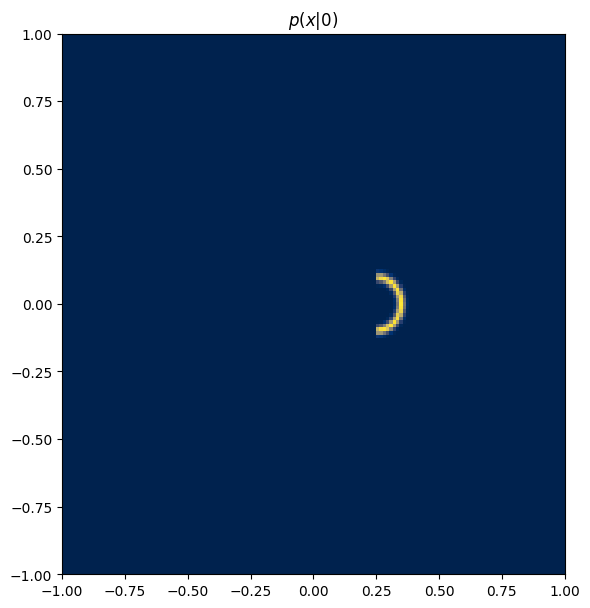

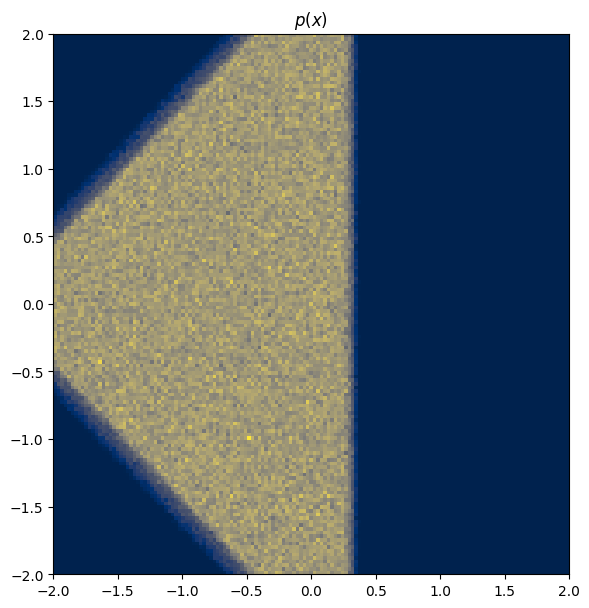

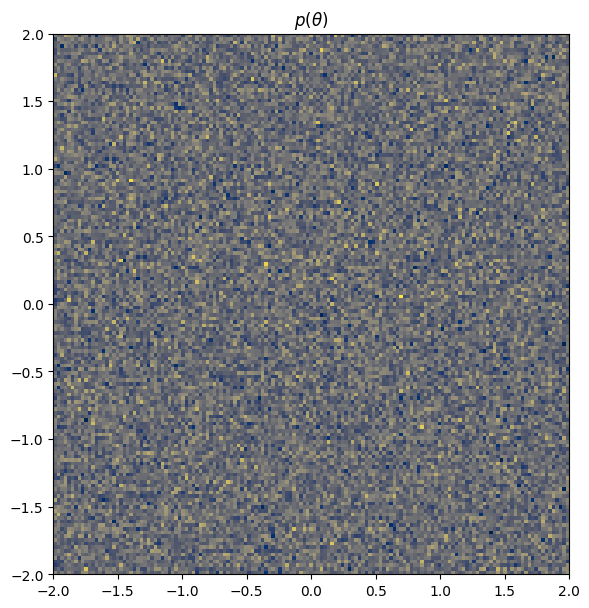

In [3]:
# Plot some distributions to get a sense of the two moons problem
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
x_samples = draw_obs(rng_batch, jnp.array([0.0, 0.0]))

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x|0)$')
plt.show()

theta_samples, x_samples = draw_batch(rng_batch)
fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-2, 2, n_bins), jnp.linspace(-2, 2, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x)$')
plt.show()
theta_samples, x_samples = draw_batch(rng_batch)
fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.hist2d(
    theta_samples[:, 0], theta_samples[:, 1], 
    bins=[jnp.linspace(-2, 2, n_bins), jnp.linspace(-2, 2, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(\theta)$')
plt.show()

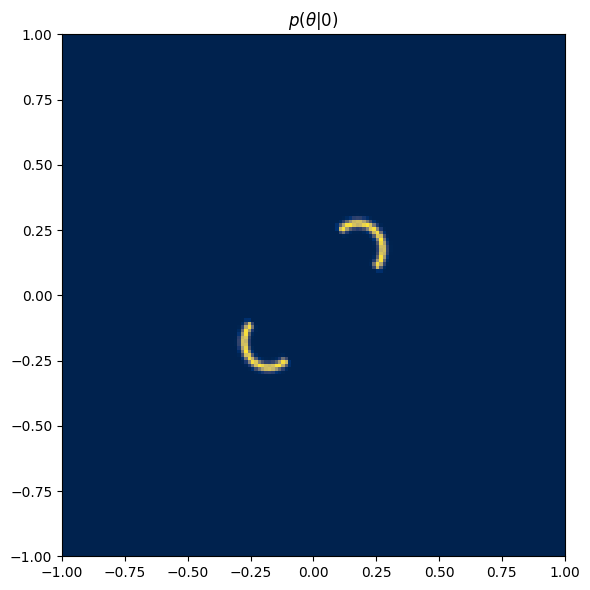

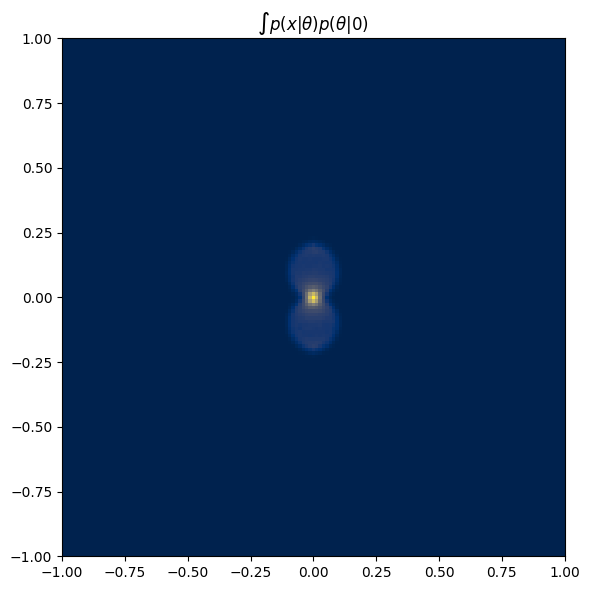

In [4]:
# Plot our target distribution for our context of 0.
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
theta_true = draw_thetas(rng_batch, jnp.array([0.0, 0.0]))
x_samples = draw_obs_conds(rng_batch, theta_true)

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.title(r'$p(\theta|0)$')
plt.hist2d(
    theta_true[:, 0], theta_true[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 6))
n_bins = 150
plt.title(r'$\int p(x|\theta)p(\theta|0)$')
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1], 
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

## Model Setup

In [6]:
parameter_dim = 2
n_maf_layers = 5
hidden_dims_maf = [32]
hidden_layers_mlp = []
activation_mlp ='gelu'
activation_maf = 'tanh'
context_dim = 2

embedding_module = embedding_models.MLP(context_dim, hidden_layers_mlp, activation_mlp)
maf_model = maf_flow.MAF(parameter_dim, n_maf_layers, hidden_dims_maf, activation_maf)
model = maf_flow.EmbeddedFlow(embedding_module, maf_model)

# Initialize the train state.
rng = jax.random.PRNGKey(1)
optimizer = 'adam'
learning_rate = 1e-3
steps_per_epoch = 1_000
learning_rate_schedule = optax.exponential_decay(learning_rate, steps_per_epoch, 0.9)
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)
sample_func = jax.jit(
    functools.partial(state.apply_fn, method='sample', mutable=('batch_stats',)),
    static_argnames=['sample_shape',]
)
log_prob_func = jax.jit(
    functools.partial(state.apply_fn, mutable=('batch_stats',))
)
# If you change the underlying model, you must create a new train_step function since it depends on the
# optimizer mask which depends on the maf_model structure.
train_step = jax.jit(train.train_step, static_argnames=['learning_rate_schedule', 'n_atoms'])

In [7]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps = []
x_batch_samps = []
log_obs_probs = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)

    theta_batch, x_batch = draw_batch(rng_batch)
    batch = {'truth': theta_batch, 'context': x_batch}
    
    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior, 
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            rng, x_obs, 
            sample_shape=sample_shape
        )
        theta_batch_samps.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs.append(log_obs_prob)

final_broad_state = state

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '0.0593', 'loss': '1.13', 'steps_per_second': '145'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '0.829', 'loss': '0.902', 'steps_per_second': '211'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '0.238', 'loss': '0.682', 'steps_per_second': '343'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '-0.148', 'loss': '0.54', 'steps_per_second': '343'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '0.541', 'loss': '0.59', 'steps_per_second': '343'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '1.52', 'loss': '0.56', 'steps_per_second': '343'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '1.76', 'loss': '0.566', 'steps_per_second': '343'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '0.793', 'loss': '0.507', 'steps_per_second': '343'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '1.81', 'loss': '0.51', 'steps_per_second': '343'}
step 10000: 

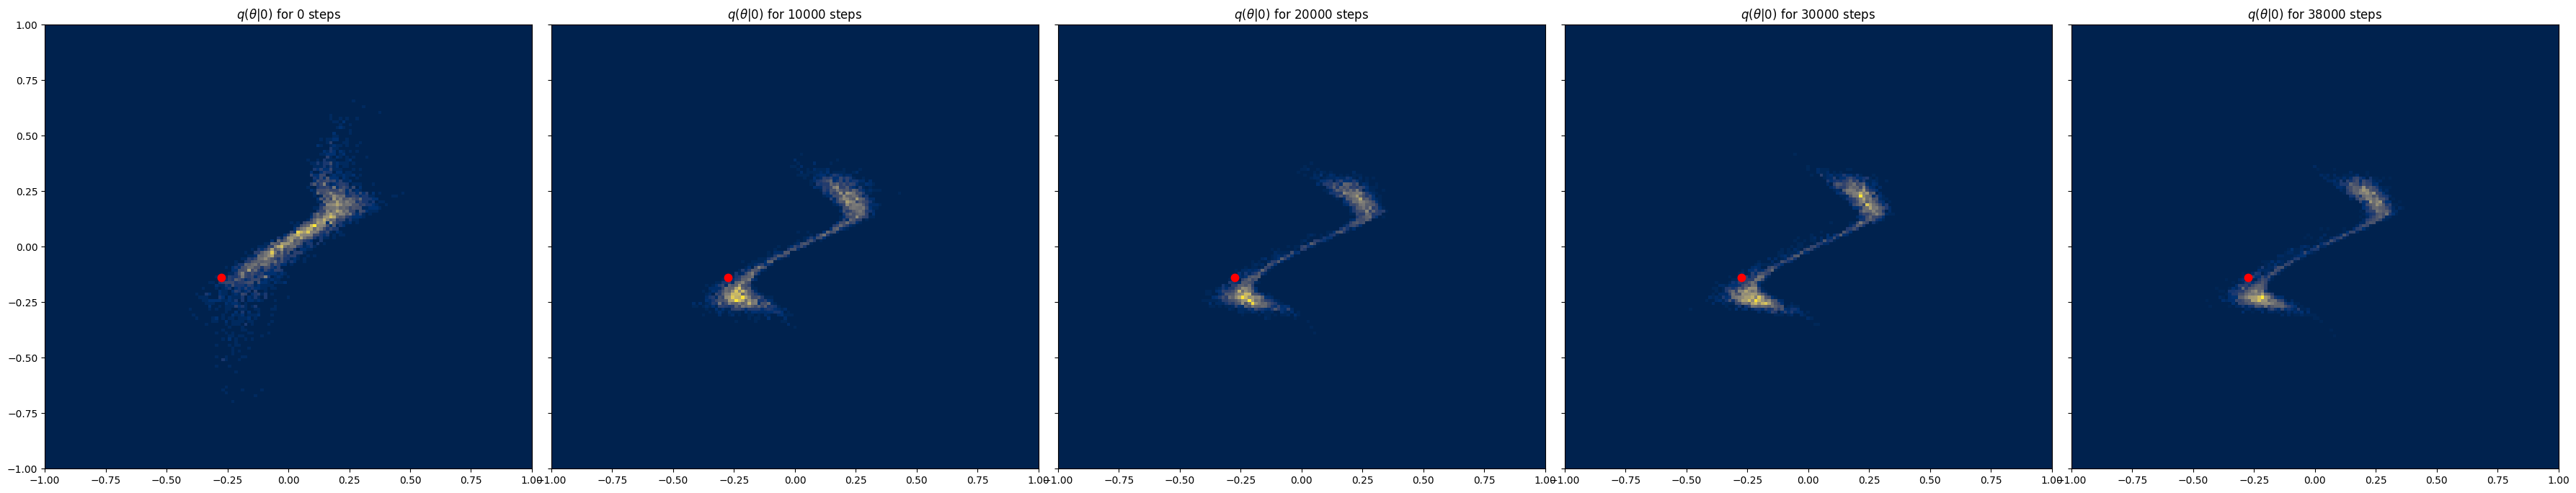

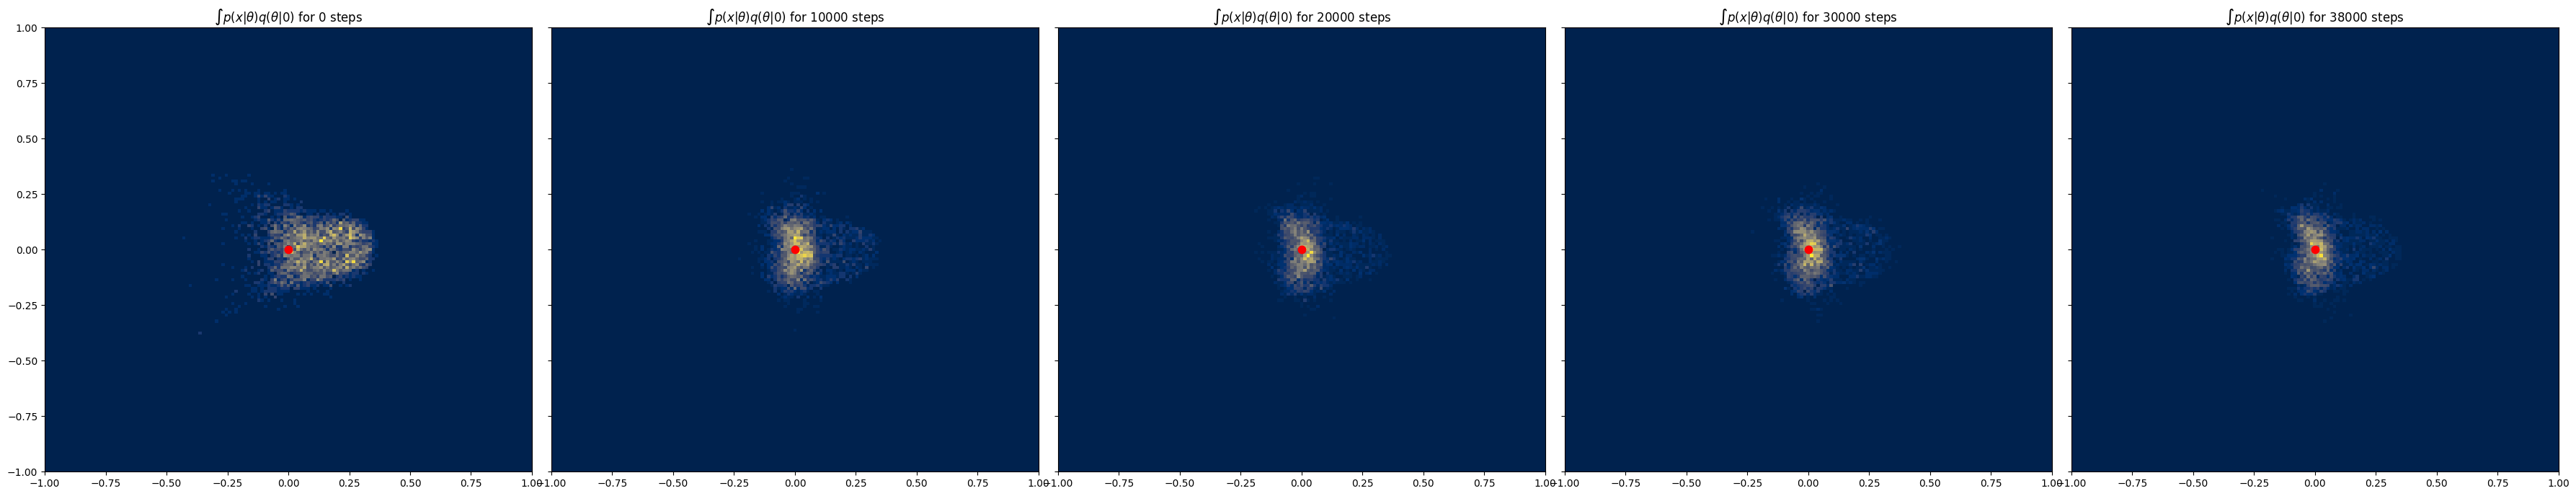

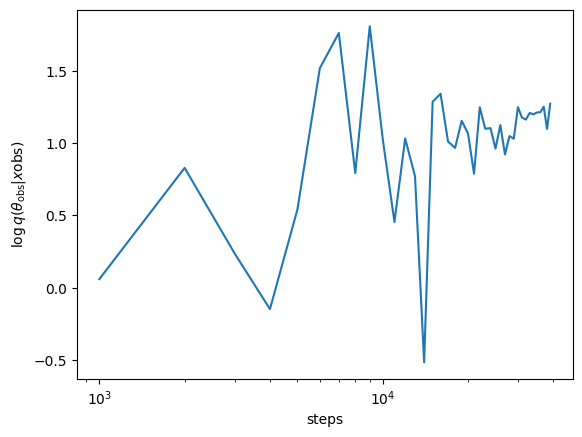

In [11]:
plt_indices = [0, 10, 20, 30, 38]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps[i][:, 0], theta_batch_samps[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps[i][:, 0], x_batch_samps[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()

In [12]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps_cond = []
x_batch_samps_cond = []
log_obs_probs_cond = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)
    theta_batch, _ = sample_func(
        {'params': final_broad_state.params, 'batch_stats': final_broad_state.batch_stats}, 
        rng, x_obs, sample_shape=(batch_size,)
    )
    theta_batch = jnp.squeeze(theta_batch)
    x_batch = draw_obs_conds(rng_batch, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}
    
    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior, 
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            rng, x_obs, 
            sample_shape=sample_shape
        )
        theta_batch_samps_cond.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_cond.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs_cond.append(log_obs_prob)

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '2.59', 'loss': '3.98', 'steps_per_second': '146'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '2.84', 'loss': '3.79', 'steps_per_second': '329'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '3.11', 'loss': '3.79', 'steps_per_second': '329'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '3.11', 'loss': '3.8', 'steps_per_second': '329'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '3.09', 'loss': '3.78', 'steps_per_second': '329'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '3.05', 'loss': '3.68', 'steps_per_second': '329'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '3.11', 'loss': '3.65', 'steps_per_second': '329'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '3.3', 'loss': '3.43', 'steps_per_second': '329'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '3.35', 'loss': '3.57', 'steps_per_second': '329'}
step 10000: {'learning_rat

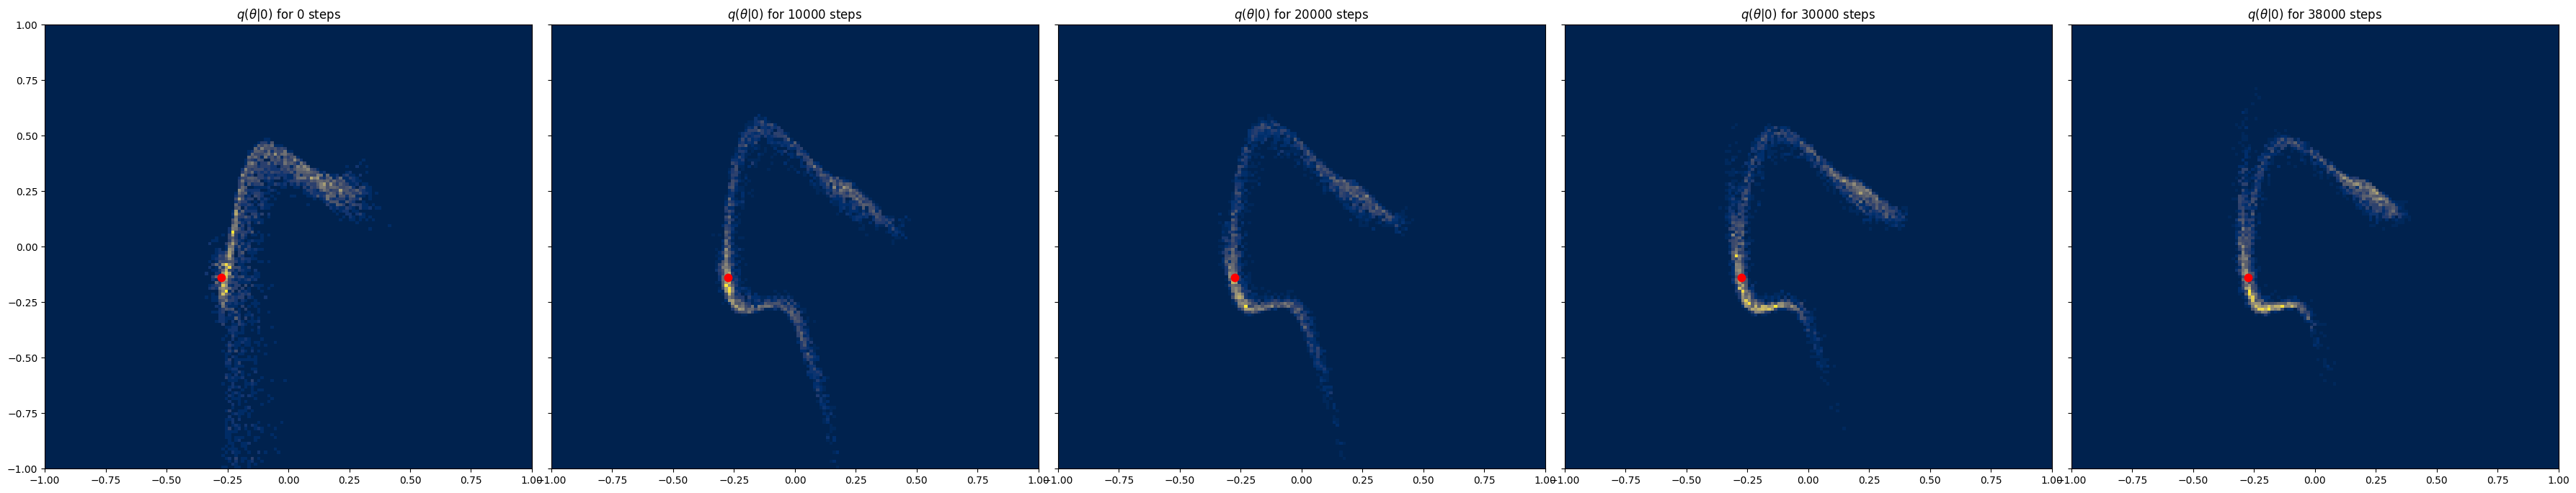

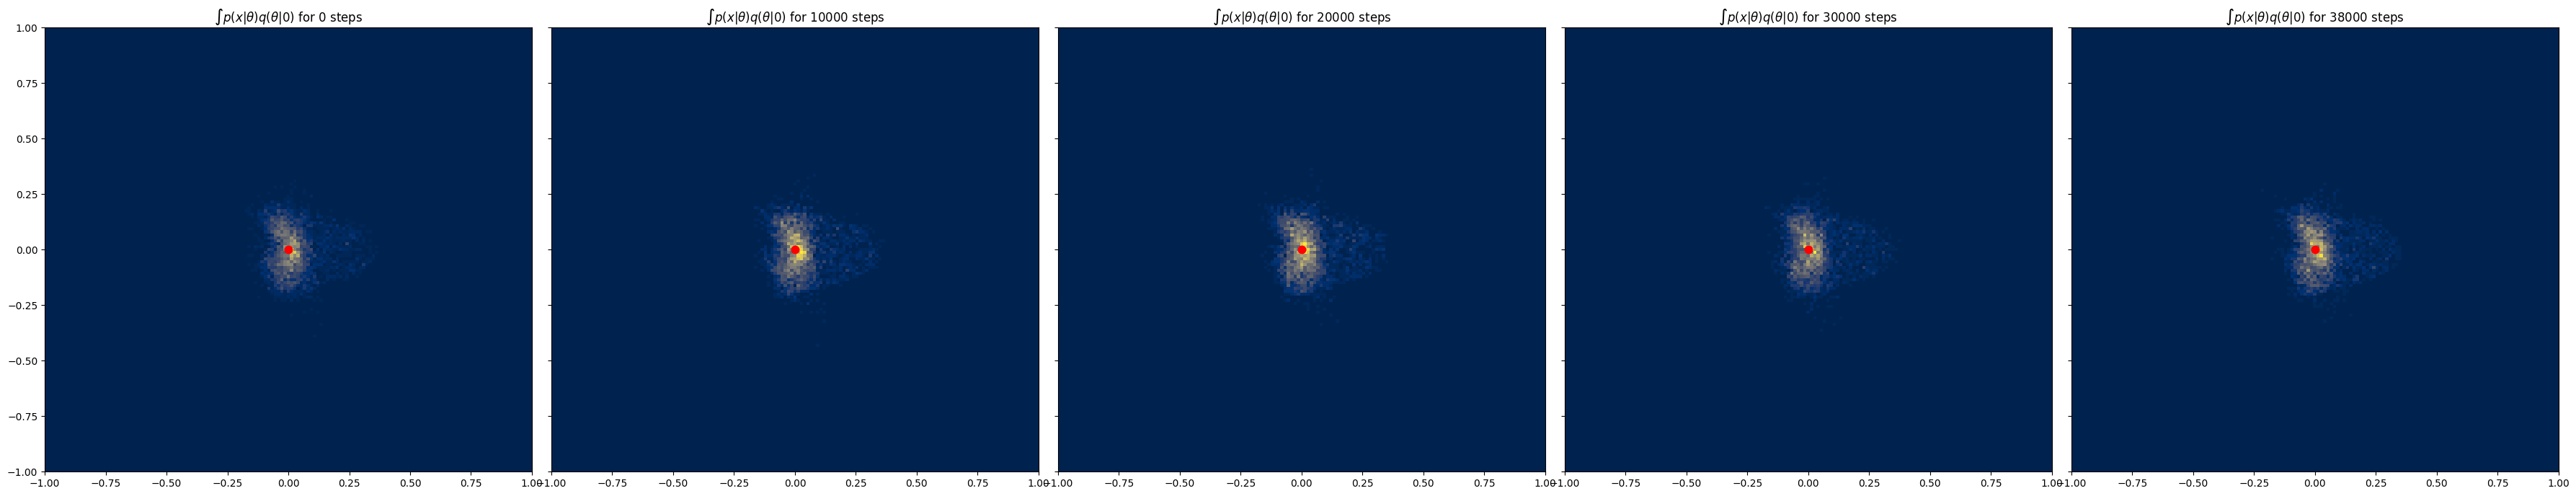

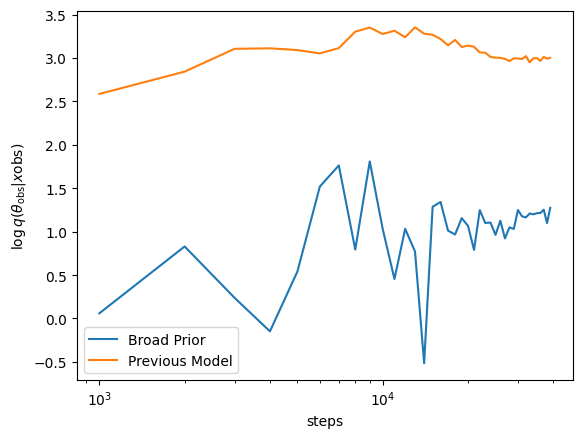

In [13]:
plt_indices = [0, 10, 20, 30, 38]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps_cond[i][:, 0], theta_batch_samps_cond[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps_cond[i][:, 0], x_batch_samps_cond[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_cond))
plt.legend(['Broad Prior', 'Previous Model'])
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()

In [18]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
warmup_steps = 5_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps_seq = []
x_batch_samps_seq = []
log_obs_probs_seq = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)
    if step < warmup_steps:
        theta_batch, x_batch = draw_batch(rng_batch)
    else:
        theta_batch, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            rng, x_obs, sample_shape=(batch_size,)
        )
        theta_batch = jnp.squeeze(theta_batch)
        x_batch = draw_obs_conds(rng_batch, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}
    
    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior, 
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats}, 
            rng, x_obs, 
            sample_shape=sample_shape
        )
        theta_batch_samps_seq.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_seq.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs_seq.append(log_obs_prob)

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '0.0593', 'loss': '1.13', 'steps_per_second': '177'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '0.829', 'loss': '0.902', 'steps_per_second': '344'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '0.238', 'loss': '0.682', 'steps_per_second': '344'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '-0.148', 'loss': '0.54', 'steps_per_second': '344'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '0.71', 'loss': '4', 'steps_per_second': '344'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '1.62', 'loss': '3.55', 'steps_per_second': '329'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '1.49', 'loss': '3.4', 'steps_per_second': '329'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '1.05', 'loss': '3.36', 'steps_per_second': '329'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '2.38', 'loss': '3.39', 'steps_per_second': '329'}
step 10000: {'learni

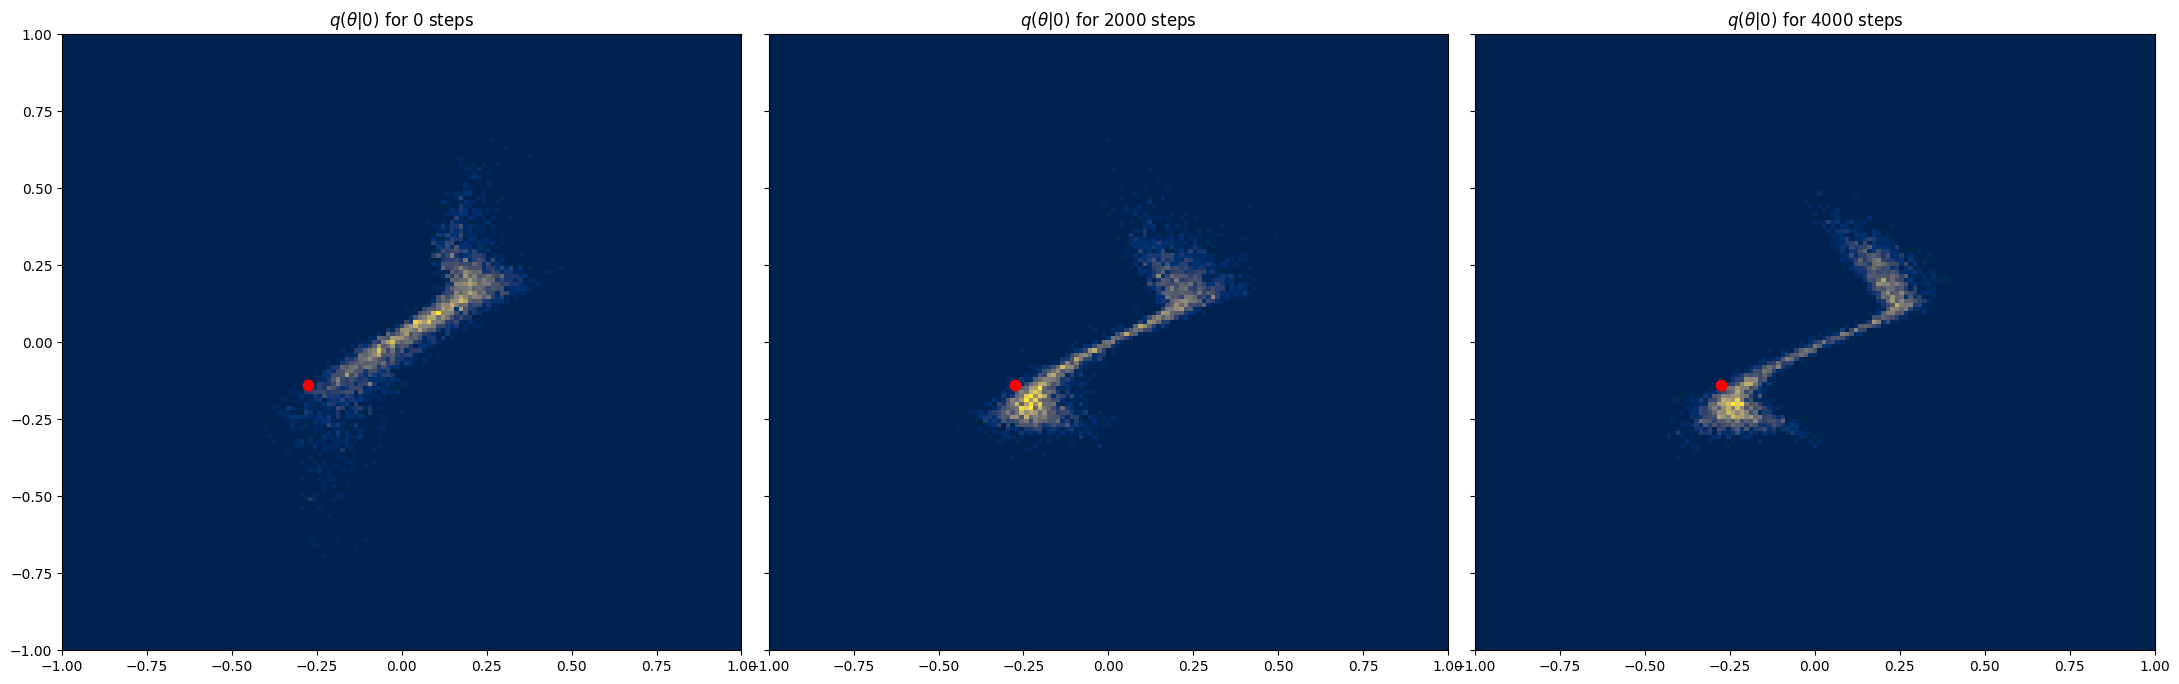

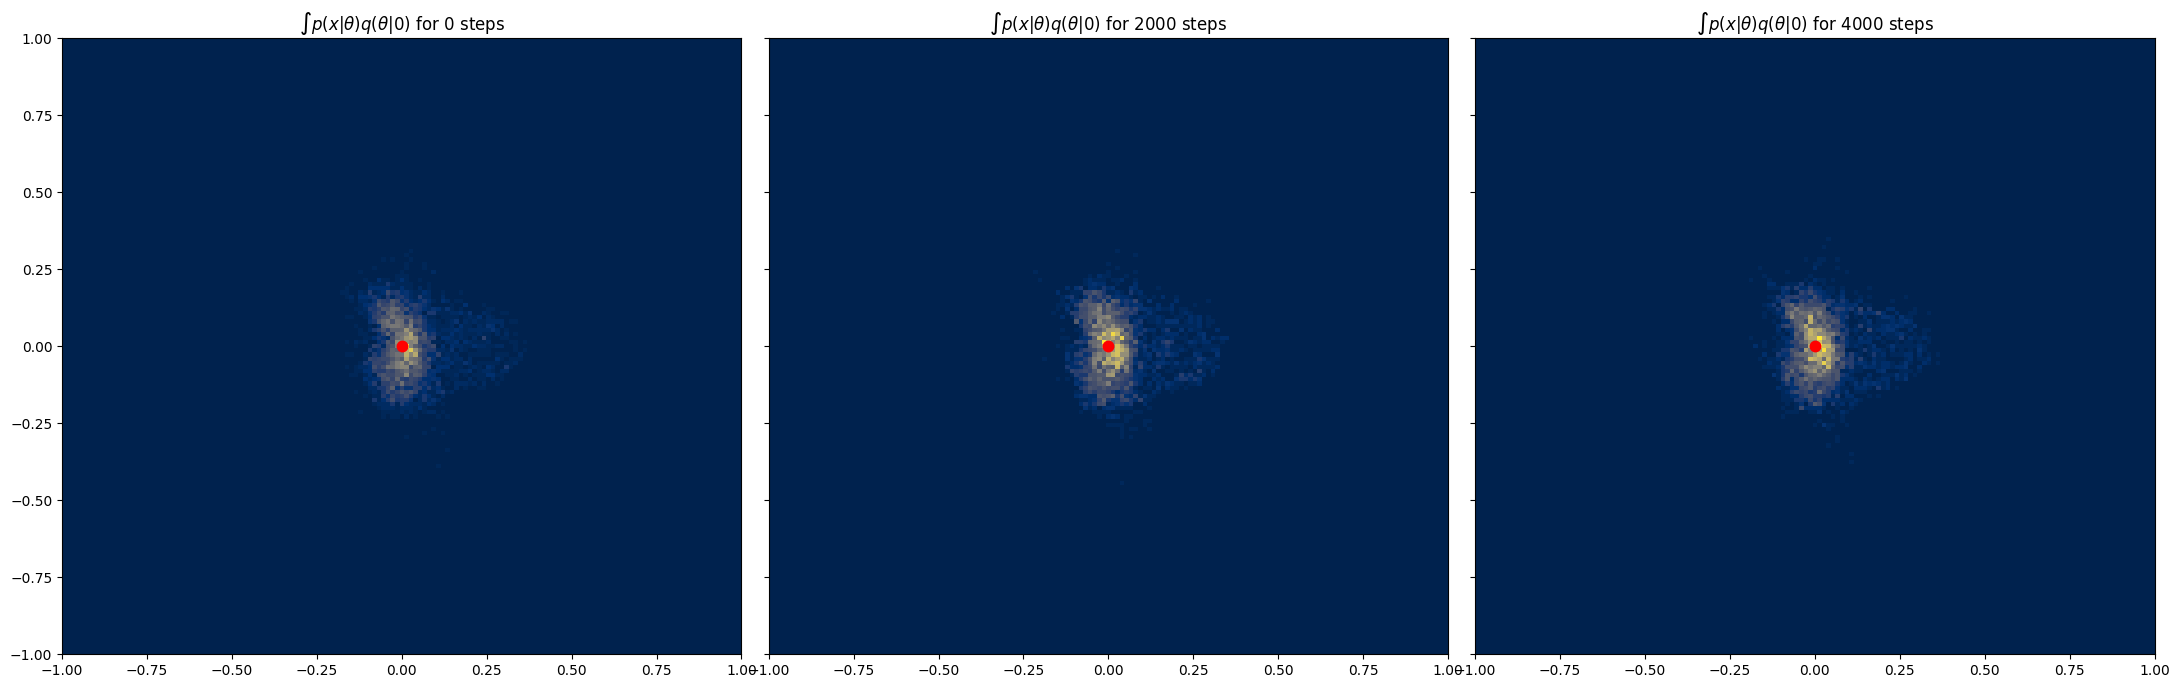

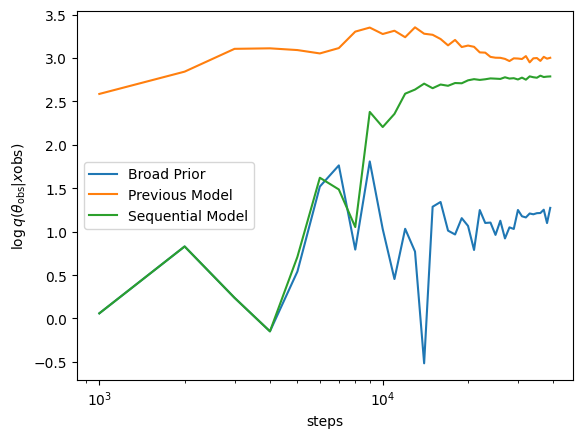

In [19]:
plt_indices = [0, 2, 4]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps_seq[i][:, 0], theta_batch_samps_seq[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True, 
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps_seq[i][:, 0], x_batch_samps_seq[i][:, 1], 
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_cond))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_seq))
plt.legend(['Broad Prior', 'Previous Model', 'Sequential Model'])
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()